In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install mlflow
import mlflow
from mlflow.tracking import MlflowClient
import mlflow.sklearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.1/575.1 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [37]:
# Létrehozzuk a FastAPI backend fájlt (main.py)
with open("main.py", "w") as f:
    f.write('''
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np

# FastAPI alkalmazás inicializálása
app = FastAPI()

# Modell betöltése
model = joblib.load("decision_tree_model.pkl")

# Adatmodell a kérésekhez
class PredictionRequest(BaseModel):
    features: list  # A bemeneti jellemzők listája

# Predikciós endpoint
@app.post("/predict")
def predict(data: PredictionRequest):
    # A bemeneti adatot numpy array-é alakítjuk
    input_features = np.array(data.features).reshape(1, -1)
    prediction = model.predict(input_features)
    return {"prediction": int(prediction[0])}
    ''')

print("main.py fájl sikeresen létrehozva!")

# Létrehozzuk a Streamlit frontend fájlt (app.py)
with open("app.py", "w") as f:
    f.write('''
import streamlit as st
import requests

# Streamlit alkalmazás címe
st.title("Decision Tree Model - Predikció")

# Bemeneti adatok bekérése
st.write("Add meg az adatok jellemzőit:")
age = st.number_input("Age", min_value=0, max_value=100, value=20)
gender = st.selectbox("Gender", options=["Male", "Female"])
admission_test_score = st.number_input("Admission Test Score", min_value=0.0, max_value=100.0, value=50.0)
high_school_percentage = st.number_input("High School Percentage", min_value=0.0, max_value=100.0, value=70.0)
city = st.selectbox("City", options=["City1", "City2", "City3"])  # Példaként

# Konvertálás a modell bemenetéhez szükséges formátumba
gender_encoded = 0 if gender == "Male" else 1
city_encoded = 0 if city == "City1" else 1 if city == "City2" else 2  # Példaként
input_features = [age, gender_encoded, admission_test_score, high_school_percentage, city_encoded]

# Predikció indítása
if st.button("Predikció"):
    response = requests.post("http://127.0.0.1:8000/predict", json={"features": input_features})
    if response.status_code == 200:
        prediction = response.json()["prediction"]
        st.write(f"A predikció: {'Accepted' if prediction == 1 else 'Rejected'}")
    else:
        st.write("Hiba történt a predikció során.")
    ''')

print("app.py fájl sikeresen létrehozva!")


main.py fájl sikeresen létrehozva!
app.py fájl sikeresen létrehozva!


In [2]:
data = pd.read_csv("student_admission_record_dirty.csv")

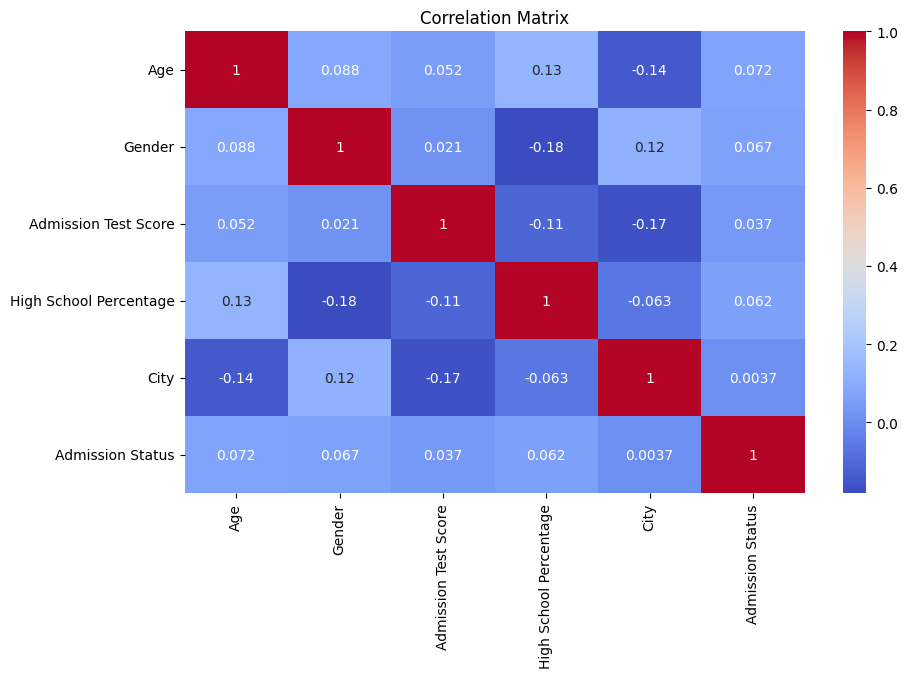

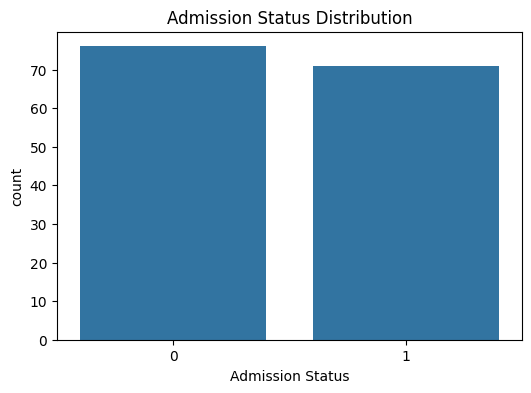

Train size: 117, Test size: 30


In [3]:
# 1. Adattisztítás
# Távolítsuk el az irreleváns oszlopokat (pl. "Name")
data_cleaned = data.drop(columns=["Name"])

# Hiányzó értékek kitöltése numerikus oszlopok esetén az átlaggal
numerical_columns = ["Age", "Admission Test Score", "High School Percentage"]
data_cleaned[numerical_columns] = data_cleaned[numerical_columns].fillna(data_cleaned[numerical_columns].mean())

# A cél változóból távolítsuk el a hiányzó értékeket
data_cleaned = data_cleaned.dropna(subset=["Admission Status"])

# 2. Átalakítások
# Kategóriák kódolása (pl. "Gender" és "City")
data_cleaned["Gender"] = data_cleaned["Gender"].map({"Male": 0, "Female": 1})
data_cleaned["City"] = data_cleaned["City"].astype("category").cat.codes
data_cleaned["Admission Status"] = data_cleaned["Admission Status"].map({"Rejected": 0, "Accepted": 1})

# 3. Gyors elemzések
import matplotlib.pyplot as plt
import seaborn as sns

# Korrelációs mátrix
plt.figure(figsize=(10, 6))
sns.heatmap(data_cleaned.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Felvételi státusz eloszlása
plt.figure(figsize=(6, 4))
sns.countplot(x="Admission Status", data=data_cleaned)
plt.title("Admission Status Distribution")
plt.show()

# 4. Modell előkészítés
from sklearn.model_selection import train_test_split

# Független változók (X) és célváltozó (y)
X = data_cleaned.drop(columns=["Admission Status"])
y = data_cleaned["Admission Status"]

# Adatok szétválasztása tréning és tesztelési halmazra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ellenőrzés
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [8]:
from sklearn.impute import SimpleImputer

# Imputer alkalmazása az X adatokra
imputer = SimpleImputer(strategy='mean')  # Numerikus oszlopok esetén az átlaggal pótol
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


In [10]:
# 5. Modellek és hiperparaméterek
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ["liblinear", "lbfgs"]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [3, 5, 10],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 10],
            "min_samples_split": [2, 5, 10]
        }
    }
}

# 6. GridSearch alkalmazása
best_models = {}
grid_results = {}

for name, model_info in models.items():
    print(f"Futás: {name}")
    grid_search = GridSearchCV(model_info["model"], model_info["params"], cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    grid_results[name] = {
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }
    print(f"Legjobb paraméterek: {grid_search.best_params_}")
    print(f"Legjobb pontszám: {grid_search.best_score_}")
    print("-" * 50)

# 7. Kiértékelés a teszt adatokon
results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    results[name] = {"accuracy": accuracy, "classification_report": report}
    print(f"Modell: {name}")
    print("Pontosság:", accuracy)
    print(report)
    print("=" * 50)


Futás: Logistic Regression
Legjobb paraméterek: {'C': 0.1, 'solver': 'lbfgs'}
Legjobb pontszám: 0.4971014492753623
--------------------------------------------------
Futás: Decision Tree
Legjobb paraméterek: {'max_depth': 5, 'min_samples_split': 2}
Legjobb pontszám: 0.5387681159420289
--------------------------------------------------
Futás: Random Forest
Legjobb paraméterek: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}
Legjobb pontszám: 0.5221014492753623
--------------------------------------------------
Modell: Logistic Regression
Pontosság: 0.4666666666666667
              precision    recall  f1-score   support

           0       0.67      0.32      0.43        19
           1       0.38      0.73      0.50        11

    accuracy                           0.47        30
   macro avg       0.52      0.52      0.46        30
weighted avg       0.56      0.47      0.45        30

Modell: Decision Tree
Pontosság: 0.4666666666666667
              precision    recall  

In [12]:
# Eredmények vizualizálása
grid_results_df = pd.DataFrame(grid_results).T
print(grid_results_df)

                                                           best_params  \
Logistic Regression                      {'C': 0.1, 'solver': 'lbfgs'}   
Decision Tree                 {'max_depth': 5, 'min_samples_split': 2}   
Random Forest        {'max_depth': 3, 'min_samples_split': 2, 'n_es...   

                    best_score  
Logistic Regression   0.497101  
Decision Tree         0.538768  
Random Forest         0.522101  


In [13]:
from sklearn.metrics import classification_report, accuracy_score
import joblib

In [14]:
# Teszt adatok kiértékelése
best_decision_tree = best_models["Decision Tree"]
y_pred = best_decision_tree.predict(X_test)

# Eredmények kiíratása
accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree Teszt Pontosság:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Modell mentése
joblib.dump(best_decision_tree, "decision_tree_model.pkl")
print("A modell elmentve: decision_tree_model.pkl")


Decision Tree Teszt Pontosság: 0.4666666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.42      0.50        19
           1       0.35      0.55      0.43        11

    accuracy                           0.47        30
   macro avg       0.48      0.48      0.46        30
weighted avg       0.52      0.47      0.47        30

A modell elmentve: decision_tree_model.pkl


In [17]:
!pip install fastapi
from fastapi import FastAPI
from pydantic import BaseModel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.4 MB/s eta 0:00:00


In [18]:
# FastAPI alkalmazás inicializálása
app = FastAPI()

# Modell betöltése
model = joblib.load("decision_tree_model.pkl")

# Adatmodell a kérésekhez
class PredictionRequest(BaseModel):
    features: list  # A bemeneti jellemzők listája

# Predikciós endpoint
@app.post("/predict")
def predict(data: PredictionRequest):
    # A bemeneti adatot numpy array-é alakítjuk
    input_features = np.array(data.features).reshape(1, -1)
    prediction = model.predict(input_features)
    return {"prediction": int(prediction[0])}


In [35]:
!pip install uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.0 MB/s eta 0:00:00


In [36]:
!uvicorn main:app --reload --host 0.0.0.0 --port 8000

INFO:     Will watch for changes in these directories: ['/content']
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [10781] using StatReload
INFO:     Started server process [10783]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [10783]
INFO:     Stopping reloader process [10781]


In [21]:
!pip install streamlit
import streamlit as st
import requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.9 MB/s eta 0:00:00


In [22]:
# Streamlit alkalmazás címe
st.title("Decision Tree Model - Predikció")

# Bemeneti adatok bekérése
st.write("Add meg az adatok jellemzőit:")
age = st.number_input("Age", min_value=0, max_value=100, value=20)
gender = st.selectbox("Gender", options=["Male", "Female"])
admission_test_score = st.number_input("Admission Test Score", min_value=0.0, max_value=100.0, value=50.0)
high_school_percentage = st.number_input("High School Percentage", min_value=0.0, max_value=100.0, value=70.0)
city = st.selectbox("City", options=["City1", "City2", "City3"])  # Példaként

# Konvertálás a modell bemenetéhez szükséges formátumba
gender_encoded = 0 if gender == "Male" else 1
city_encoded = 0 if city == "City1" else 1 if city == "City2" else 2  # Példaként
input_features = [age, gender_encoded, admission_test_score, high_school_percentage, city_encoded]

# Predikció indítása
if st.button("Predikció"):
    response = requests.post("http://127.0.0.1:8000/predict", json={"features": input_features})
    if response.status_code == 200:
        prediction = response.json()["prediction"]
        st.write(f"A predikció: {'Accepted' if prediction == 1 else 'Rejected'}")
    else:
        st.write("Hiba történt a predikció során.")


2024-11-29 13:51:50.460 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-29 13:51:50.670 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-11-29 13:51:50.676 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-29 13:51:50.679 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-29 13:51:50.686 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-29 13:51:50.694 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-29 13:51:50.697 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-29 13:51:50.700 Thread 'MainThread': mi

In [33]:
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼
added 22 packages in 3s
⠼
⠼3 packages are looking for funding
⠼  run `npm fund` for details
⠼

In [41]:
!lt --port 8000

your url is: https://bumpy-icons-argue.loca.lt
^C


In [39]:
!streamlit run app.py & lt --port 8000

your url is: https://neat-worms-greet.loca.lt



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.221.15.48:8501

  Stopping...
^C
